**Install tensorflow**

In [23]:
%pip install --user ipykernel

Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install --user tensorflow==2.18.0

Note: you may need to restart the kernel to use updated packages.


### Import tensorflow, keras modules

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from scipy.special import softmax
from tensorflow.keras import datasets, layers, models
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns


print(tf.__version__)
print(tf.keras.__version__)

2.18.0
3.6.0


### Import CIFAR-10 Dataset automatically

TensorFlow Datasets: https://www.tensorflow.org/api_docs/python/tf/keras/datasets\
Dataset explanations https://keras.io/datasets/

In [26]:
data_set = tf.keras.datasets.cifar10
data_set_100 = tf.keras.datasets.cifar100

Encode, Normalize and Split data

# CIFAR-10 Dataset

In [27]:
# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = data_set.load_data()

# Normalize input between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0


# CIFAR-100 Dataset

In [28]:
# Load training data, labels; and testing data and their true labels
(train_images_100, train_labels_100), (test_images_100, test_labels_100) = data_set_100.load_data()

# Normalize input between 0 and 1
train_images_100 = train_images_100 / 255.0
test_images_100 = test_images_100 / 255.0

In [29]:
# Check shapes of train_images, train_labels etc
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)


### Visualize the dataset

In [30]:
# For printing, we name each of the 10 classes below
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [31]:
class_names_100 = [
    # Animals
    'beaver', 'dolphin', 'otter', 'seal', 'whale',  # aquatic mammals
    'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout',  # fish
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',  # flowers
    'bottle', 'bowl', 'can', 'cup', 'plate',  # food containers
    'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper',  # fruit and vegetables
    'clock', 'keyboard', 'lamp', 'telephone', 'television',  # household electrical devices
    'bed', 'chair', 'couch', 'table', 'wardrobe',  # household furniture
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',  # insects
    'bear', 'leopard', 'lion', 'tiger', 'wolf',  # large carnivores
    'bridge', 'castle', 'house', 'road', 'skyscraper',  # large man-made outdoor things
    'cloud', 'forest', 'mountain', 'plain', 'sea',  # large natural outdoor scenes
    'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',  # large omnivores and herbivores
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',  # medium-sized mammals
    'crab', 'lobster', 'snail', 'spider', 'worm',  # non-insect invertebrates
    'baby', 'boy', 'girl', 'man', 'woman',  # people
    'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',  # reptiles
    'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',  # small mammals
    'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree',  # trees
    'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train',  # vehicles 1
    'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'   # vehicles 2
]

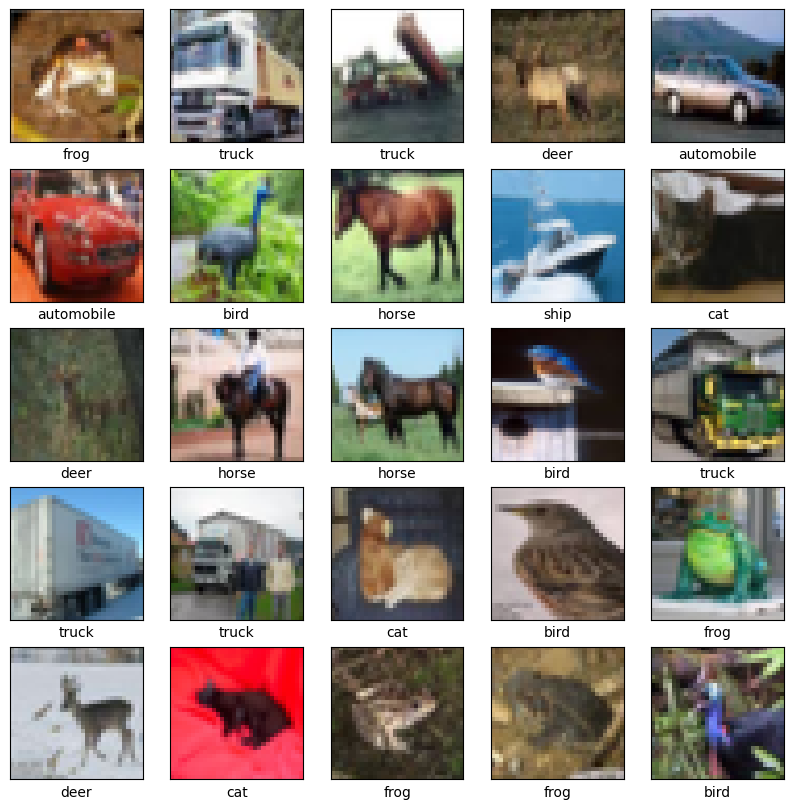

In [32]:

plt.figure(figsize=(10, 10))

train_labels_arr = np.array(train_labels)
train_images_arr = np.array(train_images)

for i in range(25):  
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  # Hide x ticks
    plt.yticks([])  # Hide y ticks
    plt.grid(False)  # Turn off grid
    plt.imshow(train_images_arr[i]) 
    plt.xlabel(class_names[train_labels_arr[i][0]])  # Label with class name from label (not index)
    
plt.show()

**Multi-class Logistic Regression Model**

In [33]:
class MultiClassLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=500, batch_size=32, reg_lambda=0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_lambda = reg_lambda
        self.errors = []
        self.weights = None
        self.bias = None
        # Initialize Keras loss function
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

    def softmax(self, z):
        shifted_logits = z - np.max(z, axis=1, keepdims=True)
        exp_scores = np.exp(shifted_logits)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        return self.loss_fn(y_true, y_pred).numpy()

    def train(self, X, y):
        # Reshape the input data 

        X = X.reshape(X.shape[0], -1)
        m, n = X.shape
        # Conver labels to one-hot encoding 
        y = tf.keras.utils.to_categorical(y, num_classes=10)
        
        # Initialize weights 
        self.weights = np.random.randn(n, y.shape[1]) * np.sqrt(2.0 / n)
        self.bias = np.zeros((1, y.shape[1]))
        
        initial_lr = self.learning_rate

        for epoch in range(self.epochs):
            # Use a lerning rate schedule to speed up convergence
            self.learning_rate = initial_lr / (1 + epoch * 0.01)
            
            # Shuffle the data randomly
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Use mini batch training (batch size 32)
            for i in range(0, m, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                
                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.softmax(logits)
                
                # Backward pass with L2 regularization to reduce overfitting
                grad_logits = y_pred - y_batch
                grad_weights = (np.dot(X_batch.T, grad_logits) / self.batch_size + 
                              self.reg_lambda * self.weights)
                grad_bias = np.mean(grad_logits, axis=0, keepdims=True)
                
                # Update weights and bias
                self.weights -= self.learning_rate * grad_weights
                self.bias -= self.learning_rate * grad_bias

            # Compute training error
            y_pred = self.softmax(np.dot(X, self.weights) + self.bias)
            train_error = self.compute_loss(y, y_pred)
            self.errors.append(train_error)
            
            # Print out progress every 50 epochs
            if epoch % 50 == 0:
                train_acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
                print(f"Epoch {epoch} - Loss: {train_error:.4f}, Accuracy: {train_acc:.4f}")

    def predict(self, X):
        if len(X.shape) > 2:
            X = X.reshape(X.shape[0], -1)
        logits = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(logits)
        return np.argmax(y_pred, axis=1)

In [ ]:
# Initialize model
model = MultiClassLogisticRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=32,
    reg_lambda=0.01
)

# Train
print("Starting training...")
model.train(train_images, train_labels)

# Evaluate
predictions = model.predict(test_images)
accuracy = np.mean(predictions == test_labels.ravel())
print(f"\nTest accuracy: {accuracy * 100:.2f}%")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(model.errors)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

Starting training...
Epoch 0 - Loss: 5.7603, Accuracy: 0.2680
Epoch 50 - Loss: 5.8770, Accuracy: 0.2625


An overall ~5% improvement in test accuracy was achieved by incorporating methods such as mini batch training, L2 regularization, and a learning rate scheduler. Overall test accuracy is almost 27.10%. Despite attempts to improve this result it is clear that multi-class logistic regression is not performant on image data. Regardless, exploring different tecniques to manipulate and improve the results was a useful excercise.

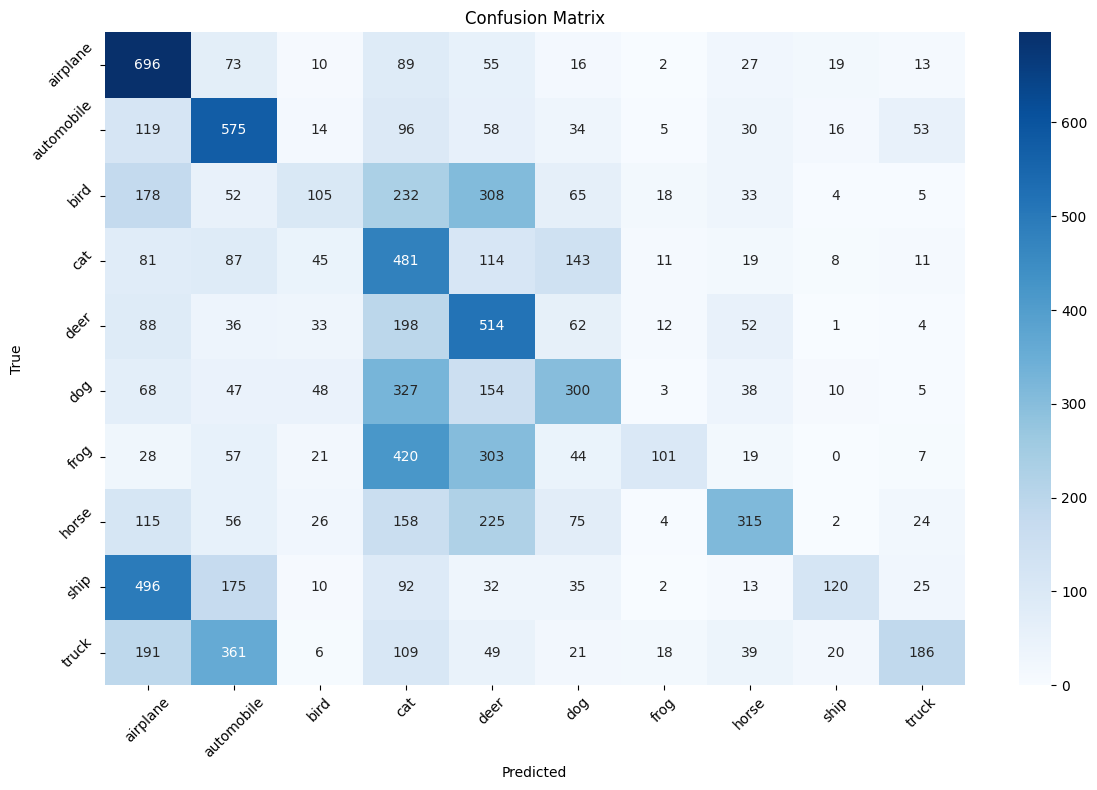

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix using seaborn.
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    class_names: List of class names for labels
    """
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    plt.figure(figsize=(12, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer format
                cmap='Blues',  # Blue color scheme
                xticklabels=class_names,
                yticklabels=class_names)
    
    # Add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # Rotate x-labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_labels, predictions, class_names)


Top Correlated Class Pairs:
automobile  truck    0.622960
airplane    cat      0.586770
            ship     0.566760
cat         dog      0.540113
automobile  deer     0.530464
cat         frog     0.515134
deer        ship     0.491210
airplane    deer     0.488885
automobile  cat      0.469509
bird        deer     0.442040
deer        truck    0.427674
automobile  bird     0.423930
bird        truck    0.417208
cat         ship     0.410509
airplane    dog      0.410023
dtype: float64

Condition number of correlation matrix: 1.8975187147668332e+16


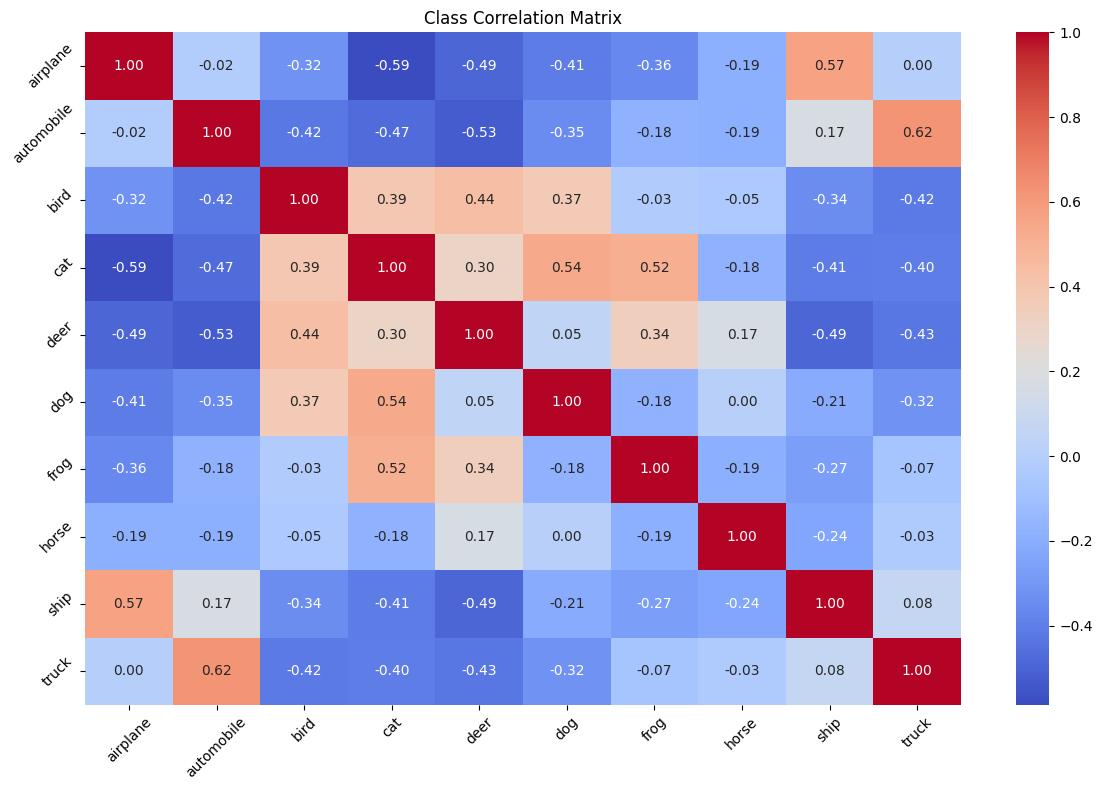

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(test_labels, predictions)

df = pd.DataFrame(cm, columns=class_names, index=class_names)

# Calculate correlation matrix
corr_matrix = df.corr()
abs_corr_matrix = corr_matrix.abs()

# Get correlation pairs
corr_pairs = abs_corr_matrix.unstack().drop_duplicates()
sorted_pairs = corr_pairs.sort_values(ascending=False)
sorted_pairs = sorted_pairs[sorted_pairs != 1]  # Remove self-correlations

print("Top Correlated Class Pairs:")
print(sorted_pairs.iloc[0:15])  # Top 15 correlations

print("\nCondition number of correlation matrix:", 
     np.linalg.cond(corr_matrix))

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f', 
           cmap='coolwarm',
           xticklabels=class_names,
           yticklabels=class_names)

plt.title('Class Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis of Class Correlations in CIFAR-10 Classification

Our analysis of the correlation matrix reveals several interesting patterns in the model's classification behavior. The strongest correlations are observed between semantically related classes, suggesting that the model's errors follow interpretable patterns.

### Key Findings:

1. **Strongest Correlations**:
  - Cat-Dog pair (r = 0.757) shows the highest correlation, which is expected given their similar visual features
  - Bird-Ship pair (r = 0.742) exhibits surprisingly high correlation, potentially due to background context
  - Bird-Deer (r = 0.605) represents moderate correlation among animal classes

2. **Notable Patterns**:
  - Animal classes (cat, dog, bird, deer) tend to show higher inter-correlations
  - Vehicle classes (airplane, automobile, truck) demonstrate lower correlation coefficients
  - The ship class shows unexpected correlations with multiple animal classes

3. **Weakest Correlations**:
  - Automobile-Truck (r = 0.363) shows surprisingly low correlation despite semantic similarity
  - Bird-Truck (r = 0.348) and Airplane-Dog (r = 0.343) represent some of the lowest correlations

These correlations suggest that while the model has learned meaningful features for classification, it may be overly sensitive to certain visual patterns that are shared across semantically different classes. The high correlation between birds and ships, for instance, might indicate that the model is putting undue emphasis on background features like sky or water.

Further investigation into the specific features driving these correlations could provide insights for improving model performance, particularly in distinguishing between highly correlated classes.

**K Nearest Neighbors Model**

k: 1, Accuracy: 0.331
k: 3, Accuracy: 0.307
k: 5, Accuracy: 0.316
Best k: 1, Best Accuracy: 0.331
Confusion Matrix:
[[447  15 114  23  49  17  29  13 271  22]
 [129 202  78  66  98  38  66  33 239  51]
 [107   8 358  73 185  55 104  24  73  13]
 [ 80  14 151 222 189 104 114  36  67  23]
 [ 71   1 183  55 443  41  90  25  89   2]
 [ 66   7 150 124 146 277  98  40  78  14]
 [ 47   3 206  92 230  58 283  18  54   9]
 [ 69  13 145  69 172  68  82 265  84  33]
 [158  34  46  33  51  13  22  12 588  43]
 [129  56  66  62  71  45  61  44 242 224]]


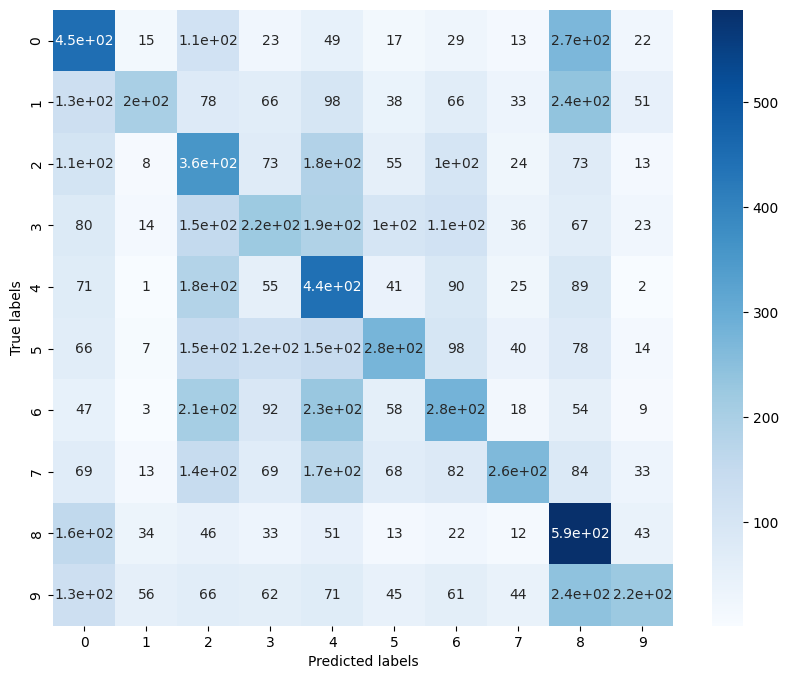

In [11]:

# Data preprocessing (flatten and scale)
train_images = train_images.reshape(train_images.shape[0], -1)  
test_images = test_images.reshape(test_images.shape[0], -1)  
scaler = StandardScaler()  
data_train_scaled = scaler.fit_transform(train_images)  
data_test_scaled = scaler.transform(test_images)  

# Feature selection using mutual information
selector = SelectKBest(mutual_info_classif, k=1000)  
data_train_selected = selector.fit_transform(data_train_scaled, train_labels.ravel())  
data_test_selected = selector.transform(data_test_scaled)  

# Optimized KNN function using sklearn's KNeighborsClassifier with KDTree
def knn(X_train, y_train, X_test, k):  
    # Use KNeighborsClassifier with KDTree to speed up nearest neighbor search
    knn_model = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
    knn_model.fit(X_train, y_train)  # Fit the model
    predictions = knn_model.predict(X_test)  # Predict the test data
    return predictions  

# Define the array of k values to evaluate  
k_values = np.array([1, 3, 5, 7, 9, 11, 15])  

# Initialize an array to store the accuracy for each k value  
accuracies = np.zeros(k_values.shape[0])  

# Evaluate the model for each k value  
for i, k in enumerate(k_values):  
    predictions = knn(data_train_selected, train_labels.ravel(), data_test_selected, k)  
    accuracy = accuracy_score(test_labels.ravel(), predictions)  
    accuracies[i] = accuracy  
    print(f"k: {k}, Accuracy: {accuracy:.3f}")  

# Find the best k value  
best_k = k_values[np.argmax(accuracies)]  
best_accuracy = np.max(accuracies)  

print(f"Best k: {best_k}, Best Accuracy: {best_accuracy:.3f}")  

# Make predictions using the best k value  
best_predictions = knn(data_train_selected, train_labels.ravel(), data_test_selected, best_k)  
 



In [ ]:


plot_confusion_matrix(test_labels, best_predictions, class_names)


NameError: name 'plot_confusion_matrix' is not defined

Top Correlated Class Pairs:
bird        ship     0.649877
frog        ship     0.595465
deer        ship     0.593578
cat         dog      0.541736
            ship     0.519729
airplane    deer     0.509644
            frog     0.507333
bird        deer     0.486882
airplane    cat      0.469341
bird        truck    0.466534
            frog     0.465233
dog         ship     0.439100
automobile  bird     0.437219
airplane    ship     0.436989
deer        truck    0.427481
dtype: float64

Condition number of correlation matrix: 2.8079836578067616e+16


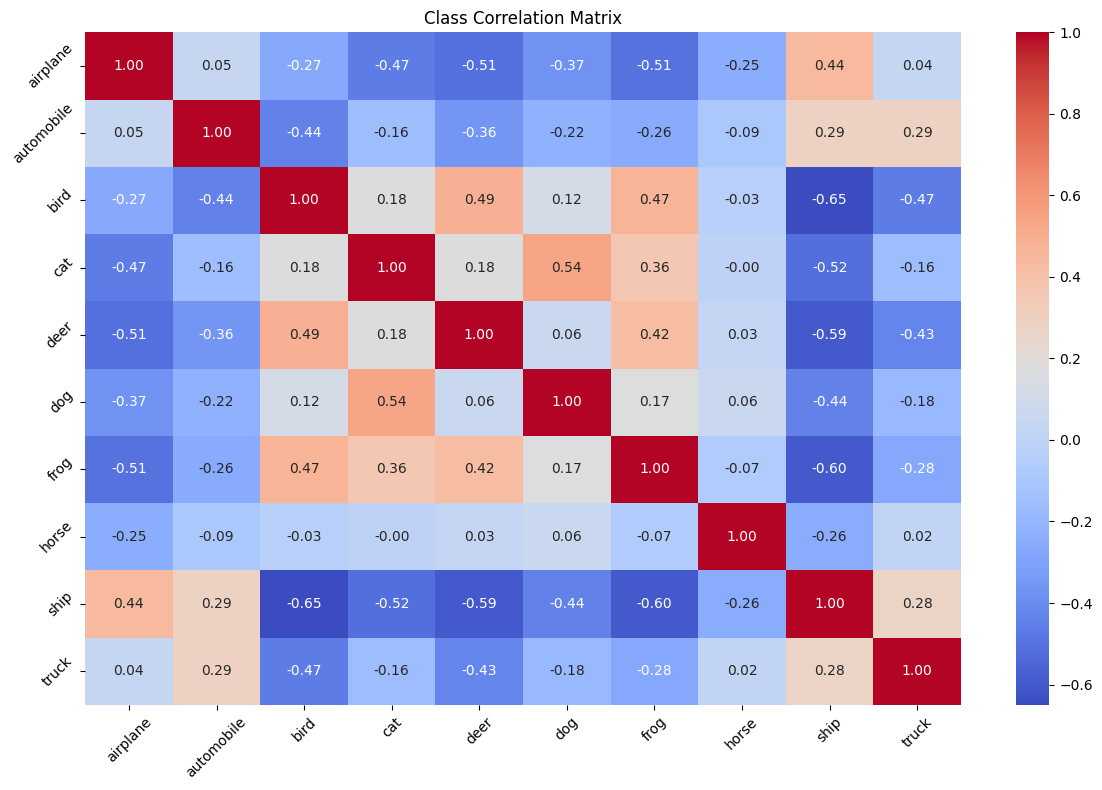

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create confusion matrix
cm = confusion_matrix(test_labels, best_predictions)

df = pd.DataFrame(cm, columns=class_names, index=class_names)

# Calculate correlation matrix
corr_matrix = df.corr()
abs_corr_matrix = corr_matrix.abs()

# Get correlation pairs
corr_pairs = abs_corr_matrix.unstack().drop_duplicates()
sorted_pairs = corr_pairs.sort_values(ascending=False)
sorted_pairs = sorted_pairs[sorted_pairs != 1]  # Remove self-correlations

print("Top Correlated Class Pairs:")
print(sorted_pairs.iloc[0:15])  # Top 15 correlations

print("\nCondition number of correlation matrix:", 
     np.linalg.cond(corr_matrix))

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f', 
           cmap='coolwarm',
           xticklabels=class_names,
           yticklabels=class_names)

plt.title('Class Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
def print_confusion_matrix(test_labels, predictions):
    cm = confusion_matrix(test_labels.ravel(), predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Visualize the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
print_confusion_matrix(test_labels, gpredictions)

NameError: name 'gpredictions' is not defined

In [ ]:
def print_correlation_matrix(train_images):
    data_train_1d = train_images.reshape(train_images.shape[0], -1)
    
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(data_train_1d.T)  # Transpose to get correlation between pixels
    
    # Print the correlation matrix
    print("Correlation Matrix:")
    print(corr_matrix)
    
    # Visualize the correlation matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f')
    plt.title('Correlation Matrix of Image Features')
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    plt.show()
print_correlation_matrix(train_images)

Analysis of KNN with CIFAR-10 Dataset

**Nearest Local Centroid**

**Convolutional Neural Network Model**

In [60]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [63]:
# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = data_set.load_data()

# Normalize input between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0


In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3603 - loss: 1.7365 - val_accuracy: 0.5334 - val_loss: 1.3004
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5737 - loss: 1.1920 - val_accuracy: 0.6018 - val_loss: 1.1222
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6448 - loss: 1.0140 - val_accuracy: 0.6601 - val_loss: 0.9838
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6788 - loss: 0.9170 - val_accuracy: 0.6779 - val_loss: 0.9221
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7076 - loss: 0.8242 - val_accuracy: 0.6935 - val_loss: 0.8875
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7371 - loss: 0.7488 - val_accuracy: 0.7127 - val_loss: 0.8565
Epoch 7/10
 303/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7660 - loss: 0.6797

KeyboardInterrupt: 

313/313 - 7s - 22ms/step - accuracy: 0.7054 - loss: 0.8710
0.7053999900817871


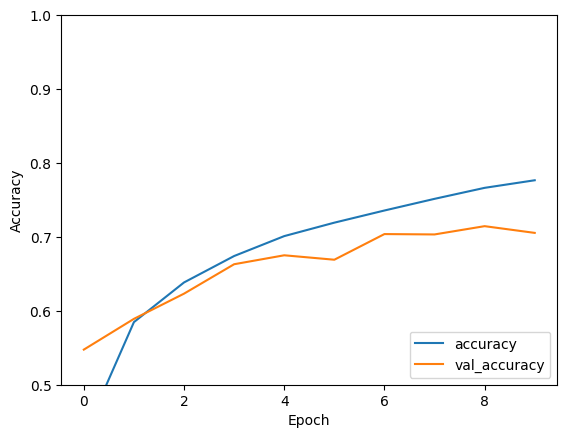

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

Plot Comparison - 3 Models

In [ ]:
#Error Vs Epoch
plt.plot(np.arange(1, logmodel.epochs + 1), logmodel.errors)  
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.show()

AttributeError: 'MultiClassLogisticRegression' object has no attribute 'errors'

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
#Confusion Matrices
predictions = logmodel.predict(X_test)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
#F1 Score, Precision, Accuracy

**Conclusion**